## (2) The DGNO method
**noise level:** $$SNR = 10\log_{10}\frac{\bar{u}}{\sigma^2},$$ where $\bar{u}=\frac{1}{n}\sum^{n}_{i=1}u^2_i$. Therefore, $$\sigma = \sqrt{\frac{\bar{u}}{10^{SNR/10}}}.$$

### (2.1) Prepare data

<KeysViewHDF5 ['a', 'index_obs', 'u', 'x']>
The noise variance is: tensor(0.0032)
a shape: torch.Size([1, 841, 1])
u shape: torch.Size([1, 841, 1])
u_noise shape: torch.Size([1, 841, 1])
x shape: torch.Size([1, 841, 2])


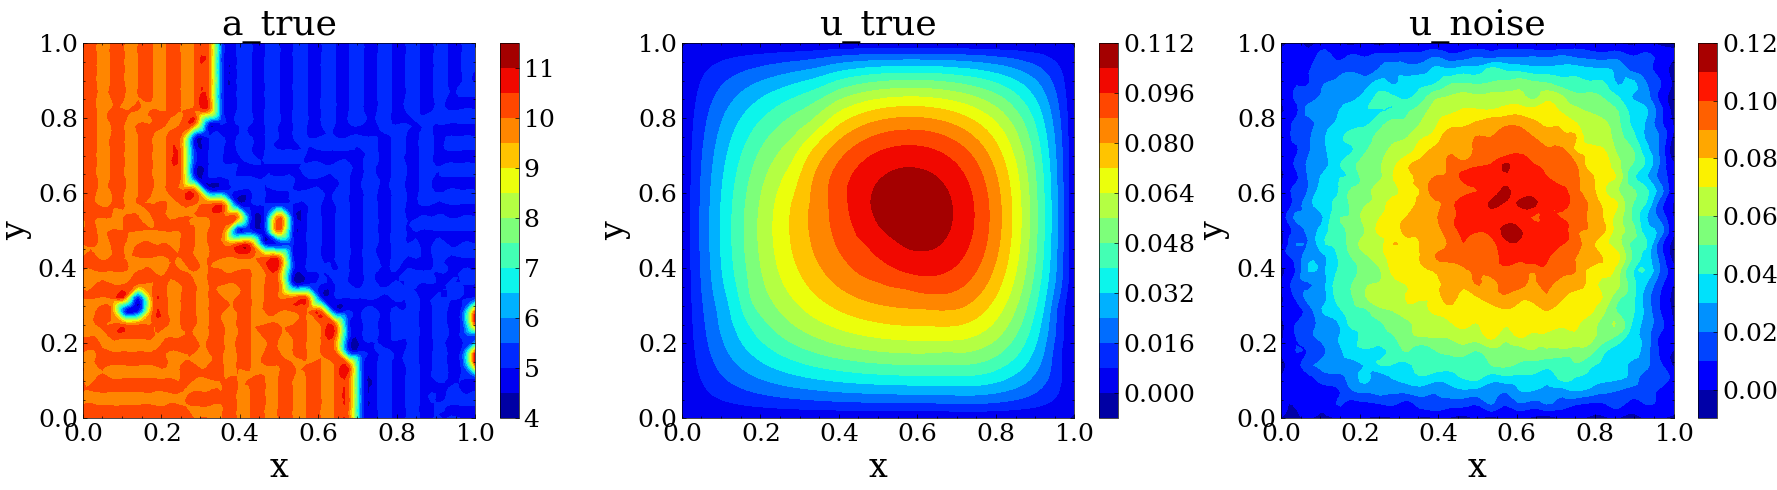

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import random
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
tag = 'DGNO'
noise_level = 'SNR25';
######################################
# Load training data
######################################
data = h5py.File('../../Problems/DarcyFlow_2d/pwc_inverse_coe.mat', 'r')
print(data.keys())
######################################
from Utils.utils import *
def get_data(data, dtype):
    gridx = np2tensor(np.array(data["x"]), dtype)
    a = np2tensor(np.array(data["a"]), dtype)
    u = np2tensor(np.array(data["u"]), dtype)
    index_obs = np.array(data["index_obs"])
    ##########################
    sig_avg_watts = torch.mean(u**2)
    #
    if noise_level=='SNR20':
        scale = np.sqrt(sig_avg_watts/10**(20/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR25':
        scale = np.sqrt(sig_avg_watts/10**(25/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR50':
        scale = np.sqrt(sig_avg_watts/10**(50/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR100':
        scale = np.sqrt(sig_avg_watts/10**(100/10))
        u_noise = u + torch.randn_like(u) * scale
    print('The noise variance is:', scale)
    
    return a.unsqueeze(0), u.unsqueeze(0), u_noise.unsqueeze(0), gridx, index_obs
#
a_true, u_true, u_noise, gridx, inx_obs = get_data(data, dtype)
x = gridx.unsqueeze(0)
print('a shape:', a_true.shape)
print('u shape:', u_true.shape)
print('u_noise shape:', u_noise.shape)
print('x shape:', x.shape)
######################################
# Generate training data
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx]*3, [a_true, u_true, u_noise], 
                  [ 'a_true', 'u_true', 'u_noise'], lb =0.)

### (2.2) Define the loss class

In [2]:
###############################
# Define Loss Class
###############################
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        xx, yy = x[...,0:1], x[...,1:2]
        u = u * torch.sin(np.pi * xx)*torch.sin(np.pi * yy) 

        return u
        
#################################
def a_sample(a_prob, samples=10):
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a
    
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.mollifer = mollifer()
        self.model_u = model_trained['u']
        self.model_s1 = model_trained['s1']
        self.model_s2 = model_trained['s2']
        self.model_a = model_trained['a']
        self.model_beta = solver.model_dict['beta_inv']
        self.ones = torch.ones((1,1,1)).to(device)
        #######################
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)
        #
        self.inx_obs = inx_obs

    def Loss_pde(self, a_batch, w_pde, nc=100, rate=1.):
        beta = self.model_beta(self.ones)
        #
        if w_pde>0.:
            n_batch = a_batch.shape[0]
            ############### Data points ###############
            xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
            xc, R = xc.to(self.device), R.to(self.device)
            nc = xc.shape[0]
            x = self.int_grid * R + xc
            x = x.reshape(-1, 2).repeat((n_batch,1,1))
            x = Variable(x, requires_grad=True)
            ############### Test functions #############
            v = self.v.repeat((nc,1,1)).reshape(-1,1)
            dv = (self.dv_dr / R).reshape(-1, 2)
            ################ model prediction ###########
            a_detach = nn.Sigmoid()(self.model_a(x.detach(), beta))
            a_detach = a_sample(a_detach)
            u = self.model_u(x, beta)
            u = self.mollifer(u, x)
            s = torch.cat([self.model_s1(x, beta), self.model_s2(x, beta)], dim=-1)
            du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            f = 10. * torch.ones_like(u)
            ################ PDE loss ####################
            res1 = torch.sum( (s - a_detach * du)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
            res1 = torch.mean(res1, dim=-1)
            #
            left = torch.sum(s * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
            left = torch.mean(left, dim=-1)
            #
            right = (f*v).reshape(n_batch, nc, self.n_grid)
            right = torch.mean(right, dim=-1)
            res2 = (left-right)**2
            ###############################################
            
            return torch.mean(res1) + torch.mean(res2) * np.sqrt(nc)
        else:
            return torch.tensor(0.)
        
    def Loss_data(self, x, a, u, w_data):
        x_obs = x[:,self.inx_obs,:]
        u_obs = u[:,self.inx_obs,:]
        if w_data:
            beta = self.model_beta(self.ones)
            u_pred = self.model_u(x_obs, beta)
            u_pred = self.mollifer(u_pred, x_obs)
            #
            loss_u = self.solver.getError(u_pred, u_obs)
        else:
            loss_u = torch.tensor(0.)
        
        return loss_u 

    def Error(self, x, a, u):
        beta = self.model_beta(self.ones)
        a_pred = nn.Sigmoid()(self.model_a(x.detach(), beta))
        a_pred = a_sample(a_pred)

        return self.solver.getError(a_pred, a)

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class BetaModel(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(BetaModel, self).__init__()
        self.fc = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, ones):
        beta = self.fc(ones)
        beta = torch.tanh(beta)
        
        return beta
#
layers_beta, act_beta = [1, 64, 64, 128], 'SiLU'
model_beta = BetaModel(layers_beta, act_beta, dtype=dtype).to(device)
######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 act_conv, act_fc,
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv=act_conv, activation_fc=act_fc,
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.tanh(x)
        
        return x
model_trained = solver.loadModel(path=f'../03_DarcyFlow_pwc/saved_models/DGNO_tanhBeta128/', 
                                 name=f'model_dgno_final')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])


### (2.3) training and make prediction

In [3]:
model_dict = {'beta_inv': model_beta}
solver.train_setup(model_dict, lr=1e-2, optimizer='Adam', scheduler_type='StepLR', 
                   step_size=100)
solver.train(LossClass, a_true, u_true, x, a_true, u_true, x, 
             w_data=25., w_pde=1., batch_size=1, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/{tag}_{noise_level}/'})

  6%|████▍                                                                           | 55/1000 [00:02<00:32, 28.74it/s]

Epoch:50 Time:2.2356, loss:0.1164, loss_pde:0.0271, loss_data:0.0036
                l2_test:0.1213, lr:0.01


 10%|████████▏                                                                      | 103/1000 [00:04<00:30, 29.21it/s]

Epoch:100 Time:3.9646, loss:0.1073, loss_pde:0.0204, loss_data:0.0035
                l2_test:0.1102, lr:0.003333333333333333


 15%|████████████▏                                                                  | 154/1000 [00:05<00:29, 29.11it/s]

Epoch:150 Time:5.6805, loss:0.0831, loss_pde:0.0180, loss_data:0.0026
                l2_test:0.1126, lr:0.003333333333333333


 20%|████████████████▏                                                              | 205/1000 [00:07<00:27, 29.25it/s]

Epoch:200 Time:7.3926, loss:0.0799, loss_pde:0.0160, loss_data:0.0026
                l2_test:0.1069, lr:0.001111111111111111


 25%|███████████████████▉                                                           | 253/1000 [00:09<00:25, 29.23it/s]

Epoch:250 Time:9.1033, loss:0.0782, loss_pde:0.0147, loss_data:0.0025
                l2_test:0.1100, lr:0.001111111111111111


 30%|████████████████████████                                                       | 304/1000 [00:10<00:23, 29.12it/s]

Epoch:300 Time:10.8142, loss:0.0770, loss_pde:0.0137, loss_data:0.0025
                l2_test:0.1081, lr:0.0003703703703703703


 36%|████████████████████████████                                                   | 355/1000 [00:12<00:22, 29.22it/s]

Epoch:350 Time:12.5317, loss:0.0767, loss_pde:0.0135, loss_data:0.0025
                l2_test:0.1098, lr:0.0003703703703703703


 40%|███████████████████████████████▊                                               | 403/1000 [00:14<00:20, 29.10it/s]

Epoch:400 Time:14.2488, loss:0.0774, loss_pde:0.0143, loss_data:0.0025
                l2_test:0.1087, lr:0.00012345679012345677


 45%|███████████████████████████████████▊                                           | 454/1000 [00:16<00:18, 29.09it/s]

Epoch:450 Time:15.9671, loss:0.0799, loss_pde:0.0168, loss_data:0.0025
                l2_test:0.1065, lr:0.00012345679012345677


 50%|███████████████████████████████████████▉                                       | 505/1000 [00:17<00:16, 29.32it/s]

Epoch:500 Time:17.6863, loss:0.0789, loss_pde:0.0158, loss_data:0.0025
                l2_test:0.1101, lr:4.1152263374485586e-05


 55%|███████████████████████████████████████████▋                                   | 553/1000 [00:19<00:15, 29.11it/s]

Epoch:550 Time:19.3935, loss:0.0775, loss_pde:0.0144, loss_data:0.0025
                l2_test:0.1034, lr:4.1152263374485586e-05


 60%|███████████████████████████████████████████████▋                               | 604/1000 [00:21<00:13, 29.22it/s]

Epoch:600 Time:21.1060, loss:0.0788, loss_pde:0.0157, loss_data:0.0025
                l2_test:0.1100, lr:1.3717421124828529e-05


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [00:22<00:11, 29.18it/s]

Epoch:650 Time:22.8230, loss:0.0752, loss_pde:0.0122, loss_data:0.0025
                l2_test:0.1079, lr:1.3717421124828529e-05


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [00:24<00:10, 29.25it/s]

Epoch:700 Time:24.5374, loss:0.0780, loss_pde:0.0150, loss_data:0.0025
                l2_test:0.1082, lr:4.572473708276176e-06


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [00:26<00:08, 29.05it/s]

Epoch:750 Time:26.2499, loss:0.0778, loss_pde:0.0148, loss_data:0.0025
                l2_test:0.1058, lr:4.572473708276176e-06


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [00:28<00:06, 29.29it/s]

Epoch:800 Time:27.9639, loss:0.0787, loss_pde:0.0157, loss_data:0.0025
                l2_test:0.1067, lr:1.5241579027587252e-06


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [00:29<00:05, 29.27it/s]

Epoch:850 Time:29.6712, loss:0.0769, loss_pde:0.0138, loss_data:0.0025
                l2_test:0.1075, lr:1.5241579027587252e-06


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [00:31<00:03, 29.06it/s]

Epoch:900 Time:31.3804, loss:0.0757, loss_pde:0.0127, loss_data:0.0025
                l2_test:0.1083, lr:5.080526342529083e-07


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [00:33<00:01, 28.93it/s]

Epoch:950 Time:33.0917, loss:0.0771, loss_pde:0.0141, loss_data:0.0025
                l2_test:0.1094, lr:5.080526342529083e-07


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.73it/s]

Epoch:1000 Time:34.8068, loss:0.0778, loss_pde:0.0148, loss_data:0.0025
                l2_test:0.1046, lr:1.6935087808430278e-07
The total training time is 34.8105


#### (2.3.2) make prediction

The shape of beta_test: torch.Size([1, 128])
The test l2 error (u avg): tensor(0.0108)
The test l2 error (a avg): tensor(0.1041)


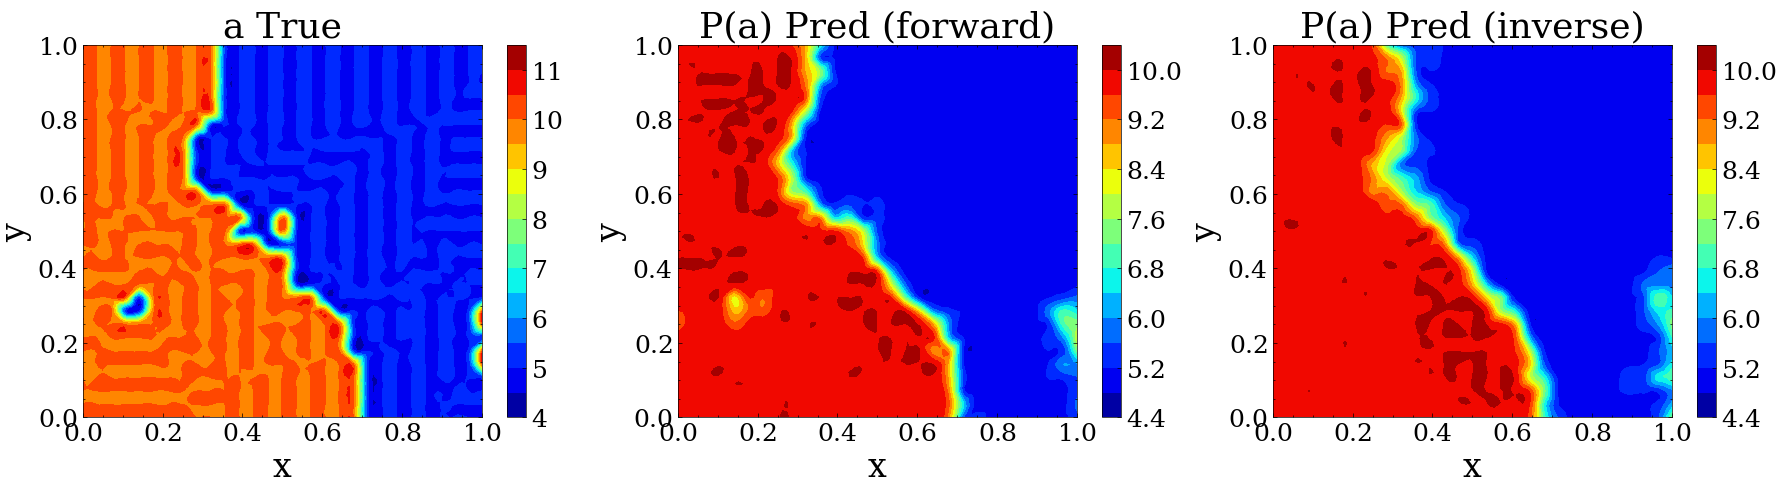

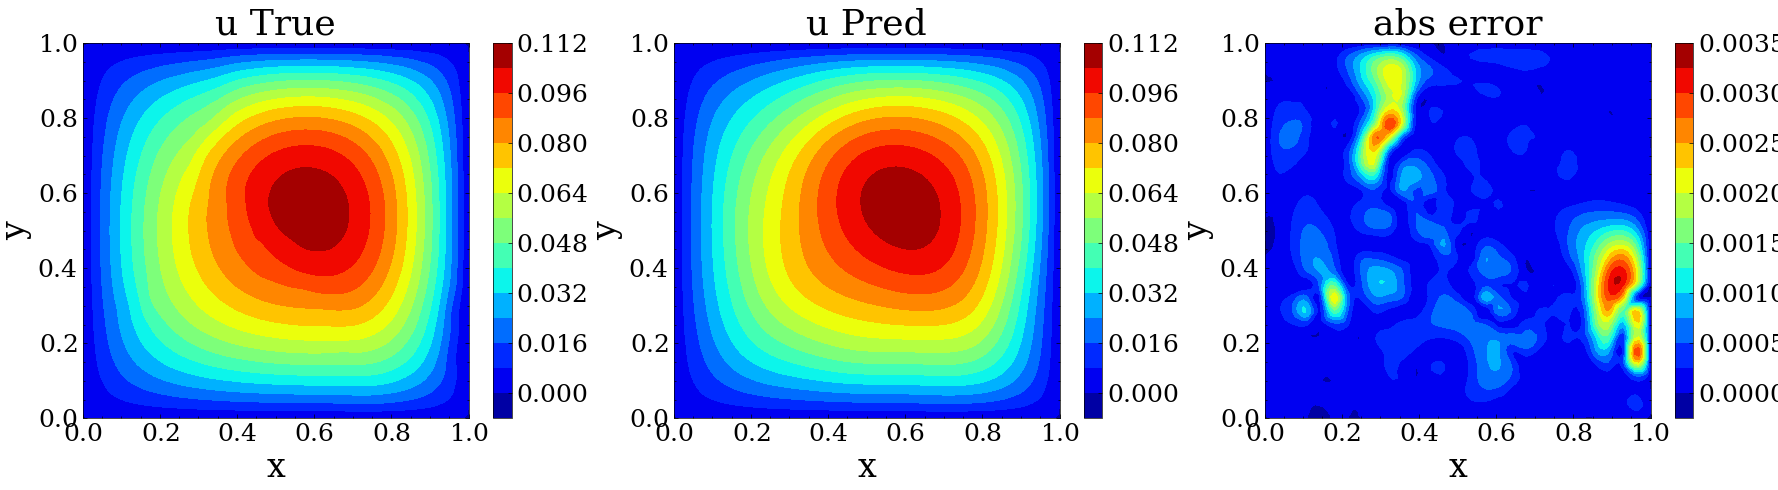

In [4]:
model_trained_inv = solver.loadModel(path=f'saved_models/{tag}_{noise_level}/', 
                                 name=f'model_dgno_final')
#########################################
def a_sample(a_prob, samples=10):
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a
#########################################    
x_coe = gridx.repeat(x.shape[0], 1, 1).to(device)
x_var = x.to(device)
beta_pred = model_trained_inv['beta_inv'](torch.ones((1,1,1)).to(device))
beta_true = model_trained['enc'](a_true.to(device))
#
u_pred = model_trained['u'](x_var, beta_pred)
u_pred = mollifer()(u_pred, x_var)
a_pred_fwd = nn.Sigmoid()(model_trained['a'](x_coe, beta_true)) 
a_pred_fwd = a_sample(a_pred_fwd)
a_pred = nn.Sigmoid()(model_trained['a'](x_coe, beta_pred))
a_pred = a_sample(a_pred)
#
u_pred = u_pred.detach().cpu()
a_pred = a_pred.detach().cpu()
a_pred_fwd = a_pred_fwd.detach().cpu()
beta_pred = beta_pred.detach().cpu()
#
print('The shape of beta_test:', beta_pred.shape)
print('The test l2 error (u avg):', solver.getError(u_pred, u_true))
print('The test l2 error (a avg):', solver.getError(a_pred, a_true))
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx, [a_true, a_pred_fwd, a_pred], 
                  ['a True', 'P(a) Pred (forward)', 'P(a) Pred (inverse)'], lb=0.)
Plot.show_2d_list(gridx, [u_true, u_pred, abs(u_pred-u_true)],
                  ['u True', 'u Pred', 'abs error'], lb=0.)